In [15]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 10,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('images/testSet_resize')):
  if i < 1000: # first 1000 will be val
    os.rename('images/testSet_resize/' + file, 'images/val/class/' + file)
  elif (1000 <= i and i < 11000): # others will be val
    os.rename('images/testSet_resize/' + file, 'images/train/class/' + file)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'images/testSet_resize'

In [16]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename='images/val/class/000c031252a1a0e0cdcfb12f44cd362d.jpg'))

FileNotFoundError: [Errno 2] No such file or directory: 'images/val/class/000c031252a1a0e0cdcfb12f44cd362d.jpg'

In [17]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time
from torch.autograd import Variable

In [18]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()

In [19]:
loss = nn.CrossEntropyLoss()

In [20]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    self.l_cent = 50.
    self.l_norm = 100.
    self.ab_norm = 110.
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.deepPaintModule = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),
      nn.ReLU(),
      nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),
      nn.Softmax(dim=1),
      nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False),
      nn.Upsample(scale_factor=4, mode='bilinear') 
    )

  def normalize_l(self, in_l):
    return (in_l-self.l_cent)/self.l_norm

  def unnormalize_l(self, in_l):
    return in_l*self.l_norm + self.l_cent

  def normalize_ab(self, in_ab):
    return in_ab/self.ab_norm

  def unnormalize_ab(self, in_ab):
    return in_ab*self.ab_norm
    
  def forward(self, input):
    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)
    print('midlevel_features shape:', midlevel_features.size())

    # Upsample to get colors
    output = self.deepPaintModule(midlevel_features)
    print('output shape:', output.size())
    return self.unnormalize_ab(output)

In [21]:
model = ColorizationNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [22]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [23]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [24]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [130]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    output_new = torch.squeeze(input_ab, 1)
    output_new = torch.argmax(output_new, dim=1)
    loss = criterion(output_ab, output_new.long())
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [131]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    output_new = torch.argmax(input_ab, dim=1)
    loss = criterion(output_ab, output_new)
    losses.update(loss.item(), input_gray.size(0))
    loss = Variable(loss, requires_grad = True)
    #print(output_new.shape)
    #loss = criterion(output_ab, output_new)
    #output_ab = model(input_gray) 
    #loss = criterion(output_ab,  input_ab.long()) 
    #losses.update(loss.item(), input_gray.size(0))
    
    #loss = Variable(loss, requires_grad = True)
    
    #losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [132]:
# Move model and loss function to GPU
if use_gpu:
    print("GPU Active")
    criterion = criterion.cuda()
    model = model.cuda()

In [133]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 250

In [135]:

# Train model
print(epochs)
epochs = 1
for epoch in range(epochs):
  # Train for one epoch, then validate
  print("training")
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
    print(losses)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

250
training
Starting training epoch 0
midlevel_features shape: torch.Size([17, 128, 28, 28])
output shape: torch.Size([17, 2, 224, 224])
Epoch: [0][0/1]	Time 2.979 (2.979)	Data 0.740 (0.740)	Loss 0.6744 (0.6744)	
Finished training epoch 0
midlevel_features shape: torch.Size([64, 128, 28, 28])
output shape: torch.Size([64, 2, 224, 224])
output_new shape: torch.Size([64, 2, 224, 224])
output_new shape: torch.Size([64, 224, 224])
Validate: [0/172]	Time 10.709 (10.709)	Loss 0.6855 (0.6855)	
midlevel_features shape: torch.Size([64, 128, 28, 28])
output shape: torch.Size([64, 2, 224, 224])
output_new shape: torch.Size([64, 2, 224, 224])
output_new shape: torch.Size([64, 224, 224])
midlevel_features shape: torch.Size([64, 128, 28, 28])
output shape: torch.Size([64, 2, 224, 224])
output_new shape: torch.Size([64, 2, 224, 224])
output_new shape: torch.Size([64, 224, 224])
midlevel_features shape: torch.Size([64, 128, 28, 28])
output shape: torch.Size([64, 2, 224, 224])
output_new shape: torch.

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

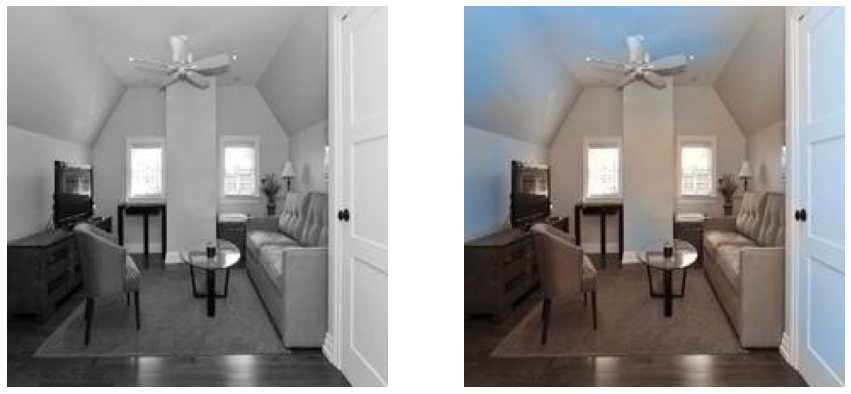

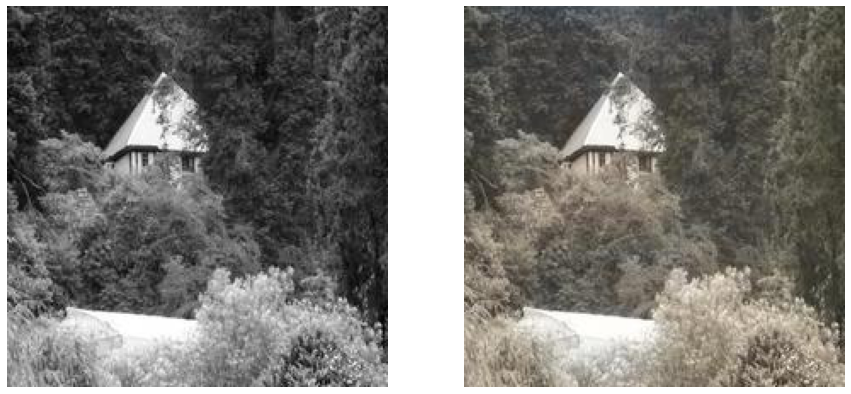

In [15]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-1-epoch-62.jpg', 'outputs/gray/img-1-epoch-0.jpg'),
               ('outputs/color/img-2-epoch-62.jpg', 'outputs/gray/img-2-epoch-0.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()